# Needed libraries

In [1]:
import numpy as np
import os
from sklearn import preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.stats import binned_statistic_2d

thismodule = sys.modules[__name__]

In [2]:
from read_lhco import read_lhco

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.lines as mlines
from xgboost import XGBRegressor, XGBClassifier
from scipy.interpolate import bisplrep,bisplev

In [225]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [5]:
import numpy as np
from scipy.optimize import fsolve

def equation(mu, pb_ps, S, B):
    return np.sum(1 / (mu * S + B * pb_ps)) - 1

def find_mu(pb_ps, S, B, mu_guess=1.0):
    mu_solution = fsolve(equation, mu_guess, args=(pb_ps, S, B))
    return mu_solution[0]


In [46]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

# Signal events

In [6]:
signal_NLO  = 1.25
luminosidad = 100

cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])

signal_cross = cross_section_bps * branching_ratios_bps *  0.2134 # fb

fid_cross_sections = np.zeros(len(cross_section_bps))
expected_events = np.zeros(len(cross_section_bps))
sim_events = np.zeros(len(cross_section_bps))
cut_events = np.zeros(len(cross_section_bps))

In [7]:
write = True

#bp_number = 1

for bp_number in [8]:

    signal_cut_ev  = 0
    signal_init_ev = 0

    counter_bad_jets = 0
    contador_tau     = 0
    signal_runs = os.listdir(f'../data/BP{bp_number}/')
    for ii, file in enumerate(signal_runs):
        print(ii)
        inputevents = read_lhco(f'../data/BP{bp_number}/' + file, OutputType = 'dict')
        signal_init_ev += len(inputevents)
        print('Esta run tuvo ' + str(len(inputevents)) + ' eventos en el lhco')
        
        for i in range(len(inputevents)):
    
            # at least one: photon, jet and lepton (electron or muon)
            if len(inputevents[i]["photon"]) > 0 and len(inputevents[i]["jet"]) > 0 and (len(inputevents[i]["electron"]) > 0 or len(inputevents[i]["muon"]) > 0):
                if inputevents[i]["jet"][0]["pt"] > 100 and -4.5 < inputevents[i]["jet"][0]["eta"] < 4.5:
                    if inputevents[i]["photon"][0]["pt"] > 10 and -2.37 < inputevents[i]["photon"][0]["eta"] < 2.37:
                        if inputevents[i]["met"][0]["pt"] > 100:
    
                            # lepton info
                            if (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) > 0):
                                if inputevents[i]["electron"][0]["pt"] > inputevents[i]["muon"][0]["pt"]: 
                                    flag = 'electron'
                                    eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                                else: 
                                    flag = 'muon'
                                    eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
                            elif (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) == 0): 
                                flag = 'electron'
                                eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                            elif (len(inputevents[i]["muon"]) > 0) and (len(inputevents[i]["electron"]) == 0): 
                                flag = 'muon'
                                eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
    
                            if (-2.47 < eta_leading_lepton < -1.52) or (-1.37 < eta_leading_lepton < 1.37) or (1.52 < eta_leading_lepton < 2.47): 
    
                                # how many jets (total) and total hadronic pT
                                flag_bad_jets = 0                            
                                num_jets = 0
                                HT_had = 0 # hadronic activity HT, defined as the scalar sum of the pT of all reconstructed jets
                                HT = 0 # total HT, defined as the scalar sum of the pT of all reconstructed particles
    
                                for j in range(len(inputevents[i]["jet"])):
                                    if (inputevents[i]["jet"][j]["pt"] > 20) and (-4.5 < inputevents[i]["jet"][j]["eta"] < 4.5):
                                        num_jets += 1
                                        HT_had += inputevents[i]["jet"][j]["pt"]
                                        HT += inputevents[i]["jet"][j]["pt"]
                                    if (np.abs(inputevents[i]["jet"][j]["eta"]) > 4.5) or (inputevents[i]["jet"][j]["pt"] < 20):
                                        flag_bad_jets = 1
    
                                # how many photons                         
                                num_photons = 0
                                for j in range(len(inputevents[i]["photon"])):
                                    if inputevents[i]["photon"][j]["pt"] > 10 and -2.37 < inputevents[i]["photon"][j]["eta"] < 2.37:
                                        num_photons = num_photons + 1
                                        HT += inputevents[i]["photon"][j]["pt"]
    
                                # how many muons                        
                                num_muons = 0
                                for j in range(len(inputevents[i]["muon"])):
                                    if inputevents[i]["muon"][j]["pt"] > 10 and -2.7 < inputevents[i]["muon"][j]["eta"] < 2.7:
                                        num_muons = num_muons + 1
                                        HT += inputevents[i]["muon"][j]["pt"]
    
                                # how many electrons                        
                                num_electrons = 0
                                for j in range(len(inputevents[i]["electron"])):
                                    if inputevents[i]["electron"][j]["pt"] > 10:
                                        eta = inputevents[i]["electron"][j]["eta"]
                                        if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                            num_electrons = num_electrons + 1
                                            HT += inputevents[i]["electron"][j]["pt"]
    
                                if flag_bad_jets == 1: counter_bad_jets += 1 
                                if flag_bad_jets == 0:
                                    num_taus = 0
                                    if len(inputevents[i]["tau"]) > 0: 
                                        contador_tau = contador_tau + 1
                                        # how many taus                    
                                        for j in range(len(inputevents[i]["tau"])):
                                            if inputevents[i]["tau"][j]["pt"] > 20:
                                                eta = inputevents[i]["tau"][j]["eta"]
                                                if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                                    num_taus = num_taus + 1
                                                    HT += inputevents[i]["tau"][j]["pt"]
    
                                    if write:                
                                        # photon info:
                                        with open(f'../data/BP{bp_number}/photon_100.dat', 'a') as f:
                                            f.write('%f %f %f %d\n' % (inputevents[i]["photon"][0]["pt"],inputevents[i]["photon"][0]["eta"],inputevents[i]["photon"][0]["phi"], num_photons))
    
                                        # jet info:
                                        with open(f'../data/BP{bp_number}/jet_100.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["jet"][0]["pt"],inputevents[i]["jet"][0]["eta"],inputevents[i]["jet"][0]["phi"]))
    
                                        # lepton info
                                        num_leptons = num_electrons + num_muons
                                        if flag == 'electron':
                                            with open(f'../data/BP{bp_number}/lepton_100.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["electron"][0]["pt"],inputevents[i]["electron"][0]["eta"],inputevents[i]["electron"][0]["phi"], num_leptons, num_taus))
                                        else:
                                            with open(f'../data/BP{bp_number}/lepton_100.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["muon"][0]["pt"],inputevents[i]["muon"][0]["eta"],inputevents[i]["muon"][0]["phi"], num_leptons, num_taus))
    
                                        # MET (eta=0 by def, but I save phi because I have many jets)
                                        with open(f'../data/BP{bp_number}/MET_100.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["met"][0]["pt"],inputevents[i]["met"][0]["eta"],inputevents[i]["met"][0]["phi"]))
    
                                        # hadronic info
                                        with open(f'../data/BP{bp_number}/hadinfo_100.dat', 'a') as f:
                                            f.write('%f %f %d\n' % (HT, HT_had, num_jets))
    
                                    # total events that passed the cuts
                                    signal_cut_ev += 1
    
    print('Num initial events: ', signal_init_ev)
    print('Total pasaron los cortes: ', signal_cut_ev)
    print('Hay: ', contador_tau, ' taus')
    print('Hay: ', counter_bad_jets, ' eventos con al menos un jet malo')
    
    
    cross       = signal_cross[bp_number-1] * signal_NLO
    aceptancia  = signal_cut_ev / signal_init_ev
    
    signal_fidcross = cross * aceptancia
    signal_expected = cross * aceptancia * luminosidad
    
    fid_cross_sections[bp_number - 1] = signal_fidcross
    expected_events[bp_number - 1] = signal_expected
    sim_events[bp_number - 1] = signal_init_ev
    cut_events[bp_number - 1] = signal_cut_ev
    print('fiducial cross section: ', signal_fidcross)
    print('Events expected: ', signal_expected)

0
Esta run tuvo 100000 eventos en el lhco
1
Esta run tuvo 100000 eventos en el lhco
2
Esta run tuvo 100000 eventos en el lhco
3
Esta run tuvo 100000 eventos en el lhco
4
Esta run tuvo 100000 eventos en el lhco
5
Esta run tuvo 100000 eventos en el lhco
6
Esta run tuvo 100000 eventos en el lhco
7
Esta run tuvo 100000 eventos en el lhco
8
Esta run tuvo 100000 eventos en el lhco
9
Esta run tuvo 100000 eventos en el lhco
10
Esta run tuvo 100000 eventos en el lhco
11
Esta run tuvo 100000 eventos en el lhco
12
Esta run tuvo 100000 eventos en el lhco
13
Esta run tuvo 100000 eventos en el lhco
14
Esta run tuvo 100000 eventos en el lhco
15
Esta run tuvo 100000 eventos en el lhco
16
Esta run tuvo 100000 eventos en el lhco
17
Esta run tuvo 100000 eventos en el lhco
18
Esta run tuvo 100000 eventos en el lhco
19
Esta run tuvo 100000 eventos en el lhco
20
Esta run tuvo 100000 eventos en el lhco
Num initial events:  2100000
Total pasaron los cortes:  344465
Hay:  4809  taus
Hay:  3155  eventos con al 

In [6]:
print('Fid cross sections: ', fid_cross_sections)
print('Expected events: ', expected_events)
print('Simulated events: ', sim_events)
print('Number of events after cuts: ', cut_events)

Fid cross sections:  [6.41574152 5.8227637  2.78895964 2.95961632 1.77368686 1.92941946
 0.92750139 1.07832349]
Expected events:  [641.57415224 582.27636959 278.8959644  295.96163172 177.36868635
 192.94194642  92.75013942 107.83234906]
Simulated events:  [1900000. 2300000. 2500000. 2000000. 2597448. 2398994. 2300000. 1000000.]
Number of events after cuts:  [257030. 279473. 279659. 279491. 374847. 372682. 317450. 163954.]


# Analysis (MET > 100)

## Reading SM data

In [8]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [9]:
wgamma_fidcross  = 584.6234
wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

1479.8648040000003

In [10]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [11]:
wgamma_expected  = 58462.34
wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

147986.4804

In [12]:
sample = 200_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [13]:
datFolderwgamma  = '../../susyatLHC/data/Wgamma/'
datFolderwjets   = '../../susyatLHC/data/Wjets/'
datFolderttgamma = '../../susyatLHC/data/ttGamma/'
datFolderttjets  = '../../susyatLHC/data/ttjets/'
datFolderzjets   = '../../susyatLHC/data/Zlep+j/'
datFolderwz      = '../../susyatLHC/data/wz/'
datFolderww      = '../../susyatLHC/data/ww/'
datFolderzz      = '../../susyatLHC/data/zz/'
datFoldertj      = '../../susyatLHC/data/singleTop+j/'
datFoldertb      = '../../susyatLHC/data/singleTop+b/'
datFoldertw      = '../../susyatLHC/data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_4.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_4.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_4.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_4.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_4.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [14]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [15]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [16]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [17]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [18]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [19]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [20]:
for i, ibkg in enumerate(bkg):
    aux = globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'ST_' + ibkg, aux)
    
    aux = np.divide( globals()['MET_' + ibkg][:,0], np.sqrt(globals()['hadinfo_' + ibkg][:,0]) )
    setattr(thismodule, 'MET_sig_' + ibkg, aux)
    
    aux = globals()['MET_' + ibkg][:,0] + globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'm_eff_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['photon_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_photon_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_jet_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['photon_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_photon_' + ibkg])) )
    setattr(thismodule, 'mT_photon_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['jet_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_jet_' + ibkg])) )
    setattr(thismodule, 'mT_jet_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['lepton_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_lepton_' + ibkg])) )
    setattr(thismodule, 'mT_lepton_' + ibkg, aux)
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_jet_' + ibkg, aux)    
    globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi]
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_lepton_' + ibkg, aux)    
    globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi]
        
    aux = np.absolute( globals()['lepton_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_lepton_jet_' + ibkg, aux)    
    globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi]
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_photon_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_jet_' + ibkg, aux)  
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['lepton_' + ibkg][:,1])**2 + (globals()['phi_photon_lepton_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (globals()['lepton_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_lepton_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_lepton_jet_' + ibkg, aux)

In [21]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [22]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## Reading NP data

In [23]:
datFolderNP = '../data/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/photon_100.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/jet_100.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/lepton_100.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/MET_100.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/hadinfo_100.dat', delimiter=' ') )

In [24]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (257030, 5)
BP2 (279473, 5)
BP3 (279659, 5)
BP4 (279491, 5)
BP5 (374847, 5)
BP6 (372682, 5)
BP7 (317450, 5)
BP8 (344465, 5)


In [25]:
signal_NLO  = 1.25
luminosidad = 100


cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])

signal_cross = cross_section_bps * branching_ratios_bps *  0.2134 # fb

sim_events = np.asarray([1_900_000., 2_300_000., 2_500_000., 2_000_000., 2_597_448., 2_398_994., 2_300_000., 2_100_000.])
cut_events = np.asarray([257_030.  , 279_473.  , 279_659.  , 279_491.  , 374_847.  , 372_682.  , 317_450.  , 344_465.])

cross       = signal_cross * signal_NLO
aceptancia  = cut_events / sim_events
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [6.41574152 5.8227637  2.78895964 2.95961632 1.77368686 1.92941946
 0.92750139 1.07882961]
Events expected:  [641.57415224 582.27636959 278.8959644  295.96163172 177.36868635
 192.94194642  92.75013942 107.88296054]


In [26]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

## Plots

In [28]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [29]:

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

In [30]:
sm_color = (1.0, 0.498, 0.314)
wjets_color = 'gray'
wgamma_color = 'gray'
ttgamma_color = 'gray'
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')

In [31]:
bkg_labels = ['W + jets', '$W \ \\gamma$', '$t \\bar{t}$ + jets', 'Z + jets', 'Single-top', '$t \\bar{t} \ \\gamma$', 'Diboson']
cmap = plt.cm.get_cmap('Reds', 8)
colors = [mpl.colors.to_hex(cmap(i+1)) for i in range(len(bkg_labels))]
cmap = cm.get_cmap('Blues', 18)

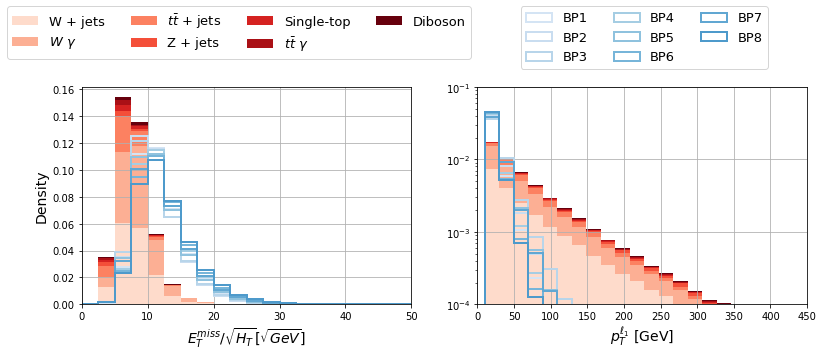

In [37]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# MET sig -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20 
bin_range = [0,50]

bkg_list = [MET_sig_wjets[:wjets_sample], MET_sig_wgamma[:wgamma_sample], MET_sig_ttjets[:ttjets_sample],
            MET_sig_zjets[:zjets_sample], 
            np.concatenate((MET_sig_tj[:tj_sample], MET_sig_tb[:tb_sample], MET_sig_tw[:tw_sample])), 
            MET_sig_ttgamma[:ttgamma_sample], 
            np.concatenate((MET_sig_zz[:zz_sample], MET_sig_wz[:wz_sample], MET_sig_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.20, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(MET_sig_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}} [\sqrt{GeV}]$",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
#ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,50)
#ax[ncol].set_ylim(5e-5,1)

# Pt lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins  = 50
bin_range = [10,1000]

bkg_list = [lepton_wjets[:wjets_sample,0], lepton_wgamma[:wgamma_sample,0], lepton_ttjets[:ttjets_sample,0],
            lepton_zjets[:zjets_sample,0],
            np.concatenate((lepton_tj[:tj_sample,0], lepton_tb[:tb_sample,0], lepton_tw[:tw_sample,0])), 
            lepton_ttgamma[:ttgamma_sample,0], 
            np.concatenate((lepton_zz[:zz_sample,0], lepton_wz[:wz_sample,0], lepton_ww[:ww_sample,0]))]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)


for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.9, 1.4), ncol = 3)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,0.1)
ax[ncol].set_xlim(0,450)

plt.savefig('../graph/MET_sig_PT_lepton_dist.pdf', bbox_inches='tight')

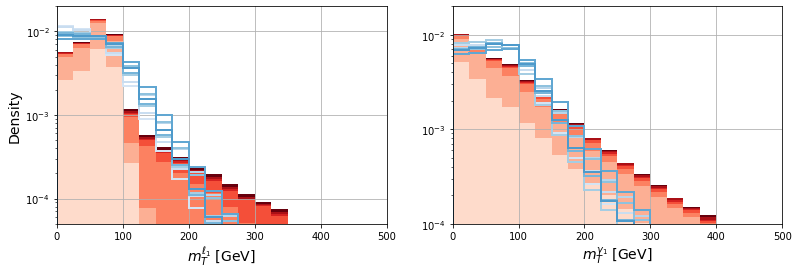

In [38]:
fig,ax = plt.subplots(1,2, figsize = (13,4))


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20
bin_range = [0,500]

bkg_list = [mT_lepton_wjets[:wjets_sample], mT_lepton_wgamma[:wgamma_sample], mT_lepton_ttjets[:ttjets_sample],
            mT_lepton_zjets[:zjets_sample], 
            np.concatenate((mT_lepton_tj[:tj_sample], mT_lepton_tb[:tb_sample], mT_lepton_tw[:tw_sample])),
            mT_lepton_ttgamma[:ttgamma_sample],
            np.concatenate((mT_lepton_zz[:zz_sample], mT_lepton_wz[:wz_sample], mT_lepton_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
#ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.35, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(mT_lepton_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,500)
ax[ncol].set_ylim(5e-5,2e-2)
ax[ncol].set_ylabel("Density",fontsize=14)

# Mt photon
ncol = 1
nbins = 20
bin_range = [0,500]

bkg_list = [mT_photon_wjets[:wjets_sample], mT_photon_wgamma[:wgamma_sample], mT_photon_ttjets[:ttjets_sample],
            mT_photon_zjets[:zjets_sample], 
            np.concatenate((mT_photon_tj[:tj_sample], mT_photon_tb[:tb_sample], mT_photon_tw[:tw_sample])),
            mT_photon_ttgamma[:ttgamma_sample],
            np.concatenate((mT_photon_zz[:zz_sample], mT_photon_wz[:wz_sample], mT_photon_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_photon_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
#ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1., 1.4), ncol = 3)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,2e-2)
ax[ncol].set_xlim(0,500)

plt.savefig('../graph/mt_lepton_mt_photon.pdf', bbox_inches='tight')

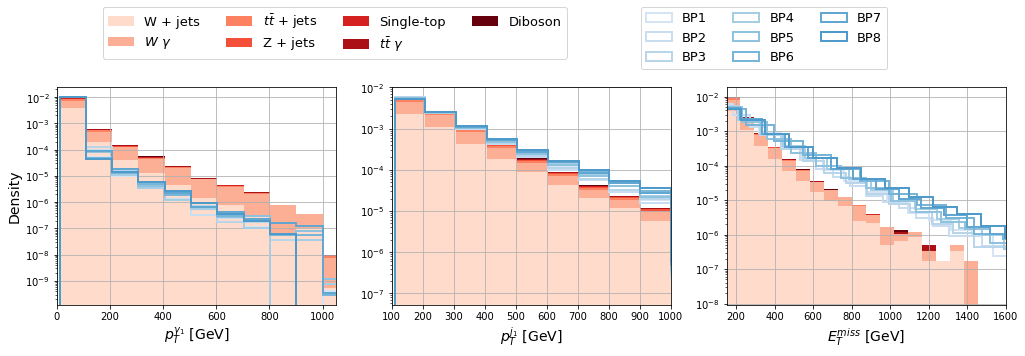

In [39]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
ncol  = 0
nbins = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [photon_wjets[:wjets_sample,0], photon_wgamma[:wgamma_sample,0], photon_ttjets[:ttjets_sample,0], 
            photon_zjets[:zjets_sample,0], 
            np.concatenate((photon_tj[:tj_sample,0], photon_tb[:tb_sample,0], photon_tw[:tw_sample,0])),
            photon_ttgamma[:ttgamma_sample,0], 
            np.concatenate((photon_zz[:zz_sample,0],photon_wz[:wz_sample,0],photon_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.85, 1.4), ncol = 4) 


for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,1050)
ax[ncol].set_ylabel("Density",fontsize=14)


# Pt jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.array([109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [jet_wjets[:wjets_sample,0], jet_wgamma[:wgamma_sample,0], jet_ttjets[:ttjets_sample,0], 
            jet_zjets[:zjets_sample,0], 
            np.concatenate((jet_tj[:tj_sample,0], jet_tb[:tb_sample,0], jet_tw[:tw_sample,0])),
            jet_ttgamma[:ttgamma_sample,0],
            np.concatenate((jet_zz[:zz_sample,0],jet_wz[:wz_sample,0],jet_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.8, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(100,1000)



# Pt MET -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 20
bin_range = [150,1600]

bkg_list = [MET_wjets[:wjets_sample,0], MET_wgamma[:wgamma_sample,0], MET_ttjets[:ttjets_sample,0], 
            MET_zjets[:zjets_sample,0], 
            np.concatenate((MET_tj[:tj_sample,0], MET_tb[:tb_sample,0], MET_tw[:tw_sample,0])),
            MET_ttgamma[:ttgamma_sample,0],
            np.concatenate((MET_zz[:zz_sample,0],MET_wz[:wz_sample,0],MET_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(MET_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(150,1600)

plt.savefig('../graph/PT_photon_PT_jet_ETmiss.pdf', bbox_inches='tight')

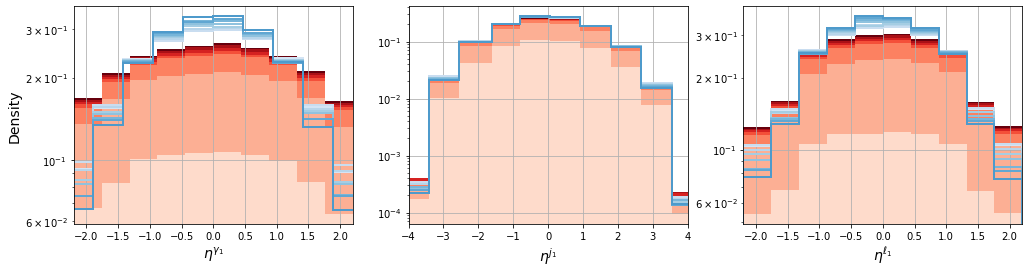

In [40]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [photon_wjets[:wjets_sample,1], photon_wgamma[:wgamma_sample,1], photon_ttjets[:ttjets_sample,1],
            photon_zjets[:zjets_sample,1], 
            np.concatenate((photon_tj[:tj_sample,1], photon_tb[:tb_sample,1], photon_tw[:tw_sample,1])),
            photon_ttgamma[:ttgamma_sample,1],
            np.concatenate((photon_zz[:zz_sample,1],photon_wz[:wz_sample,1],photon_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)
ax[ncol].set_ylabel("Density",fontsize=14)


# eta jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])

bkg_list = [jet_wjets[:wjets_sample,1], jet_wgamma[:wgamma_sample,1], jet_ttjets[:ttjets_sample,1],
            jet_zjets[:zjets_sample,1], 
            np.concatenate((jet_tj[:tj_sample,1], jet_tb[:tb_sample,1], jet_tw[:tw_sample,1])),
            jet_ttgamma[:ttgamma_sample,1], 
            np.concatenate((jet_zz[:zz_sample,1],jet_wz[:wz_sample,1],jet_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-4.,4.)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [lepton_wjets[:wjets_sample,1], lepton_wgamma[:wgamma_sample,1], lepton_ttjets[:ttjets_sample,1],
            lepton_zjets[:zjets_sample,1], 
            np.concatenate((lepton_tj[:tj_sample,1], lepton_tb[:tb_sample,1], lepton_tw[:tw_sample,1])),
            lepton_ttgamma[:ttgamma_sample,1],
            np.concatenate((lepton_zz[:zz_sample,1],lepton_wz[:wz_sample,1],lepton_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

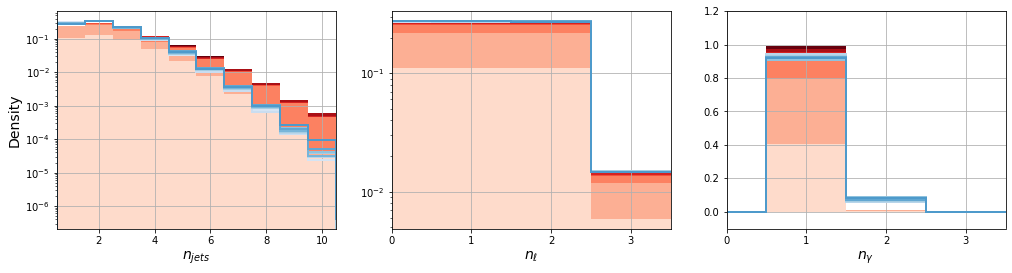

In [41]:
fig,ax = plt.subplots(1,3, figsize = (17,4))


# Num jets
ncol = 0
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

bkg_list = [hadinfo_wjets[:wjets_sample,2], hadinfo_wgamma[:wgamma_sample,2], hadinfo_ttjets[:ttjets_sample,2],
            hadinfo_zjets[:zjets_sample,2], 
            np.concatenate((hadinfo_tj[:tj_sample,2], hadinfo_tb[:tb_sample,2], hadinfo_tw[:tw_sample,2])),
            hadinfo_ttgamma[:ttgamma_sample,2],
            np.concatenate((hadinfo_zz[:zz_sample,2],hadinfo_wz[:wz_sample,2],hadinfo_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,10.5)

ax[ncol].set_ylabel("Density",fontsize=14)

# Num leptons
ncol = 1
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

bkg_list = [lepton_wjets[:wjets_sample,2], lepton_wgamma[:wgamma_sample,2], lepton_ttjets[:ttjets_sample,2],
            lepton_zjets[:zjets_sample,2], 
            np.concatenate((lepton_tj[:tj_sample,2], lepton_tb[:tb_sample,2], lepton_tw[:tw_sample,2])),
            lepton_ttgamma[:ttgamma_sample,2],
            np.concatenate((lepton_zz[:zz_sample,2],lepton_wz[:wz_sample,2],lepton_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_xticks([0,1,2,3])


# Num photons
ncol = 2
bins = [0.5,1.5,2.5,3.5,4.5]

bkg_list = [photon_wjets[:wjets_sample,3], photon_wgamma[:wgamma_sample,3], photon_ttjets[:ttjets_sample,3],
            photon_zjets[:zjets_sample,3], 
            np.concatenate((photon_tj[:tj_sample,3], photon_tb[:tb_sample,3], photon_tw[:tw_sample,3])),
            photon_ttgamma[:ttgamma_sample,3],
            np.concatenate((photon_zz[:zz_sample,3],photon_wz[:wz_sample,3],photon_ww[:ww_sample,3]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,3], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_ylim(-0.1,1.2)
ax[ncol].set_xticks([0,1,2,3])

plt.savefig('../graph/njets_nleptons_nphoton.pdf', bbox_inches='tight')

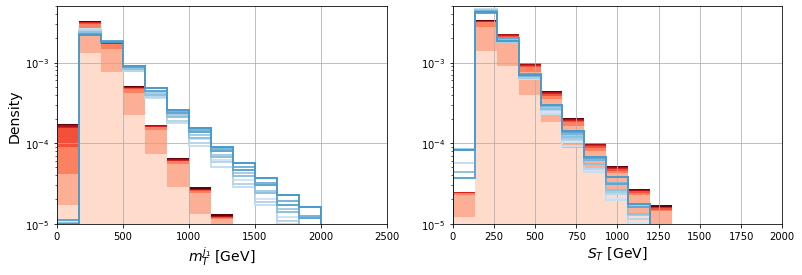

In [42]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# Mt jet info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 15
bin_range = [0,2500]

bkg_list = [mT_jet_wjets[:wjets_sample], mT_jet_wgamma[:wgamma_sample], mT_jet_ttjets[:ttjets_sample],
            mT_jet_zjets[:zjets_sample], 
            np.concatenate((mT_jet_tj[:tj_sample], mT_jet_tb[:tb_sample], mT_jet_tw[:tw_sample])),
            mT_jet_ttgamma[:ttgamma_sample],
            np.concatenate((mT_jet_zz[:zz_sample], mT_jet_wz[:wz_sample], mT_jet_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_jet_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)
ax[ncol].set_ylabel("Density",fontsize=14)


# ST info
ncol = 1
nbins = 15
bin_range = [0,2000]

bkg_list = [ST_wjets[:wjets_sample], ST_wgamma[:wgamma_sample], ST_ttjets[:ttjets_sample],
            ST_zjets[:zjets_sample], 
            np.concatenate((ST_tj[:tj_sample], ST_tb[:tb_sample], ST_tw[:tw_sample])),
            ST_ttgamma[:ttgamma_sample],
            np.concatenate((ST_zz[:zz_sample], ST_wz[:wz_sample], ST_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(ST_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2000)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/mt_jet_ST.pdf', bbox_inches='tight')

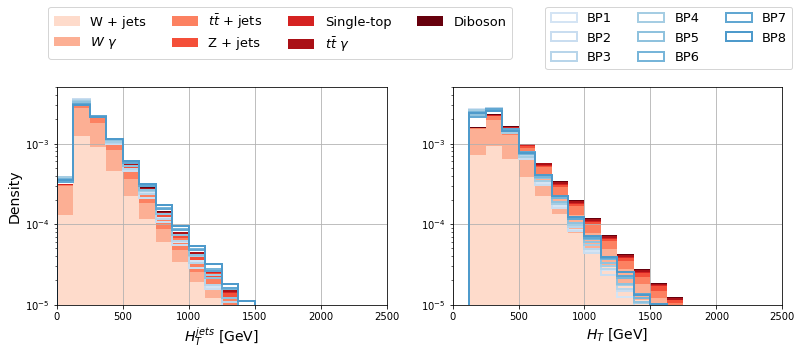

In [43]:
nbins = 20#np.asarray([121.16, 467.7, 814.2, 1160.8, 1507.3, 1853.9, 2200.4, 2546.9, 2893.5, 3240.0, 10000])

fig,ax = plt.subplots(1,2, figsize = (13,4))

# Ht info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]
bin_range = [0,2500]
nbins = 20

bkg_list = [hadinfo_wjets[:wjets_sample,1], hadinfo_wgamma[:wgamma_sample,1], hadinfo_ttjets[:ttjets_sample,1],
            hadinfo_zjets[:zjets_sample,1], 
            np.concatenate((hadinfo_tj[:tj_sample,1], hadinfo_tb[:tb_sample,1], hadinfo_tw[:tw_sample,1])),
            hadinfo_ttgamma[:ttgamma_sample,1],
            np.concatenate((hadinfo_zz[:zz_sample,1],hadinfo_wz[:wz_sample,1],hadinfo_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.40, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

# HT
ncol = 1

bkg_list = [hadinfo_wjets[:wjets_sample,0], hadinfo_wgamma[:wgamma_sample,0], hadinfo_ttjets[:ttjets_sample,0],
            hadinfo_zjets[:zjets_sample,0], 
            np.concatenate((hadinfo_tj[:tj_sample,0], hadinfo_tb[:tb_sample,0], hadinfo_tw[:tw_sample,0])),
            hadinfo_ttgamma[:ttgamma_sample,0],
            np.concatenate((hadinfo_zz[:zz_sample,0],hadinfo_wz[:wz_sample,0],hadinfo_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.05, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')

## ML Analysis

In [27]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [28]:
nobs = len(photon_SM)
#BPS_trained = np.asarray([0]) #np.arange(15)
BPS_trained = np.arange(8)
nobs_bp = round(nobs / len(BPS_trained))

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df = pd.DataFrame()

np.random.seed(28890)

mask_list = []
for bp in BPS_trained:
    print(bp)
    BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
    mask = np.ones(len(photon_NP[bp]), dtype=bool)
    mask[BP_indices] = False
    mask_list.append( mask )
    
    if bp == 0:
        
        df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
        df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
        df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
        df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

        df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
        df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
        df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

        df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
        df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
        df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
        df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
        df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

        df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
        df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

        df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
        df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
        df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

        df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
        df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

        df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
        df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
        df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


        df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

        df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])
        
        df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
        df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
        df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
        df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

        df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
        df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
        df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

        df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
        df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
        df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
        df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
        df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

        df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
        df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

        df_aux[lst[17]] = ST_NP[bp][BP_indices] 
        df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

        df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
        df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
        df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


        df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 
        
        df = pd.concat((df, df_aux))
df_array = np.asarray(df)
df

0
1
2
3
4
5
6
7


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1,bp_flag
0,109.97,-1.010,1.126,1.0,279.48,-2.172,2.048,137.82,-1.683,-0.986,...,354.91,2.0,527.27,9.682301,301.263647,513.440063,51.588819,2.0,0.0,0.0
1,60.15,-1.663,0.588,1.0,162.98,-1.049,1.255,32.82,-2.272,-1.321,...,217.16,2.0,255.95,12.290957,216.455577,375.619984,48.848456,2.0,0.0,0.0
2,11.44,0.200,-2.696,1.0,454.32,1.664,1.222,83.36,-1.797,-1.360,...,936.45,4.0,549.12,5.475962,75.386642,463.416307,78.466217,2.0,0.0,0.0
3,35.93,-1.049,-2.552,1.0,136.74,-0.159,0.109,21.16,-2.011,2.706,...,213.27,3.0,193.83,6.509908,42.249489,240.572574,15.634083,1.0,0.0,0.0
4,23.20,-0.194,0.983,1.0,120.23,1.242,0.113,26.27,1.841,-2.987,...,182.41,3.0,169.70,7.440434,95.216565,233.076793,3.709114,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,10.59,-0.046,-1.435,1.0,183.33,-0.084,1.819,43.70,-0.424,2.999,...,183.33,1.0,237.62,12.653319,13.763248,376.464423,162.553916,0.0,1.0,8.0
24996,24.94,-0.549,0.223,2.0,119.07,-0.286,1.329,12.85,0.836,2.899,...,119.07,1.0,156.86,10.126796,99.406093,249.891994,56.056683,0.0,1.0,8.0
24997,25.41,-0.025,1.519,1.0,148.19,0.799,1.990,26.09,-0.125,-1.188,...,265.04,2.0,199.69,12.849343,140.471744,363.220839,27.880735,0.0,1.0,8.0
24998,32.93,0.347,1.052,1.0,126.19,2.764,2.072,15.86,-0.982,-1.674,...,160.51,2.0,174.98,8.412821,118.817854,244.803143,12.696669,0.0,1.0,8.0


In [29]:
print('There are ' + str(len(np.where(df_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(8):
    print('There are ' + str(len(np.where(df_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 200001 bkg events
There are 25000 BP1 events
There are 25000 BP2 events
There are 25000 BP3 events
There are 25000 BP4 events
There are 25000 BP5 events
There are 25000 BP6 events
There are 25000 BP7 events
There are 25000 BP8 events


In [30]:
SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

#BPS_analyzed = np.asarray([0])
BPS_analyzed = np.arange(8)

df_test = pd.DataFrame()

for bp in BPS_analyzed:
    if bp in BPS_trained:
        mask = mask_list[np.where(BPS_trained == bp)[0][0]]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
    else:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
        mask = np.zeros(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = True
    print(bp)
    #mask = mask_list[bp]
    #mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 15000
    if bp == 0:
        
        df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
        df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
        df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
        df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

        df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
        df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
        df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

        df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
        df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
        df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
        df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
        df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

        df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
        df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

        df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
        df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
        df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

        df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
        df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

        df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
        df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
        df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


        df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

        df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])
        
        df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])
        
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][mask,0] 
        df_aux[lst[1]] = photon_NP[bp][mask,1] 
        df_aux[lst[2]] = photon_NP[bp][mask,2] 
        df_aux[lst[3]] = photon_NP[bp][mask,3] 

        df_aux[lst[4]] = jet_NP[bp][mask,0] 
        df_aux[lst[5]] = jet_NP[bp][mask,1] 
        df_aux[lst[6]] = jet_NP[bp][mask,2] 

        df_aux[lst[7]] = lepton_NP[bp][mask,0] 
        df_aux[lst[8]] = lepton_NP[bp][mask,1] 
        df_aux[lst[9]] = lepton_NP[bp][mask,2] 
        df_aux[lst[10]] = lepton_NP[bp][mask,3] 
        df_aux[lst[11]] = lepton_NP[bp][mask,4] 

        df_aux[lst[12]] = MET_NP[bp][mask,0] 
        df_aux[lst[13]] = MET_NP[bp][mask,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

        df_aux[lst[17]] = ST_NP[bp][mask] 
        df_aux[lst[18]] = MET_sig_NP[bp][mask] 

        df_aux[lst[19]] = mT_photon_NP[bp][mask] 
        df_aux[lst[20]] = mT_jet_NP[bp][mask] 
        df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


        df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))
        
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)
        
        df_test = pd.concat((df_test, df_aux))
df_test_array = np.asarray(df_test)
df_test

0
1
2
3
4
5
6
7


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1,bp_flag
0,75.69,2.167,-0.041,1.0,201.79,1.733,2.759,19.70,1.466,-1.422,...,349.90,4.0,297.18,5.808957,0.096323,309.999859,62.559993,4.0,0.0,0.0
1,18.23,0.278,-0.095,1.0,641.65,0.241,-1.695,243.75,-0.900,1.472,...,641.65,1.0,903.63,13.734996,123.683135,1029.150948,6.344640,1.0,0.0,0.0
2,11.06,0.946,-1.778,1.0,260.03,-0.405,1.240,13.14,2.014,-0.727,...,320.38,2.0,284.23,16.509843,6.633477,564.586790,69.819039,1.0,0.0,0.0
3,16.98,-2.128,-0.911,1.0,131.13,-0.720,3.090,41.66,-1.632,0.986,...,234.58,4.0,189.77,6.919078,36.127495,249.260438,71.517662,2.0,0.0,0.0
4,138.38,-0.650,2.709,1.0,105.82,0.161,-0.795,73.31,0.001,2.939,...,142.36,2.0,317.51,6.384990,271.634841,24.733093,194.649908,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92864,29.09,-1.648,1.641,2.0,352.77,-2.623,-0.745,57.59,-1.476,-2.012,...,540.78,2.0,439.45,11.406141,110.024533,616.662440,160.752142,0.0,1.0,8.0
92865,11.78,1.657,0.732,1.0,214.51,0.743,-2.170,27.40,1.509,2.217,...,356.03,3.0,253.69,10.687685,0.900509,424.357070,102.161575,0.0,1.0,8.0
92866,23.25,1.019,-1.799,1.0,398.87,0.697,0.085,12.19,0.773,1.947,...,431.39,2.0,434.31,19.465202,117.948709,819.109983,84.319937,0.0,1.0,8.0
92867,12.73,-0.024,-1.140,1.0,208.48,-0.811,0.279,17.34,-0.936,-3.014,...,482.08,3.0,238.55,16.452407,67.338161,523.380035,66.406730,0.0,1.0,8.0


In [31]:
print('There are ' + str(len(np.where(df_test_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(8):
    print('There are ' + str(len(np.where(df_test_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 439041 bkg events
There are 90368 BP1 events
There are 91037 BP2 events
There are 90949 BP3 events
There are 91100 BP4 events
There are 93278 BP5 events
There are 93346 BP6 events
There are 92078 BP7 events
There are 92869 BP8 events


In [32]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
val_size   = nobs - train_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
val_indices   = random_indices[train_size:]

In [33]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [34]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [35]:
print('y:', df.columns[-2]) # Just to check

y: SM=0 - NP=1


In [36]:
x_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_train        = df_array[train_indices, -2]

x_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_test        = df_test_array[:, -2]

x_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_val        = df_array[val_indices, -2]

In [37]:
for i, ibkg in enumerate(bkg):
    ind_train = np.where(bkg_flag_train == (i + 1))[0]
    if(len(ind_train) < globals()[ibkg + '_expected']): 
        print('In training there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_train), globals()[ibkg + '_expected']))
        
    ind_test = np.where(bkg_flag_test == (i + 1))[0]
    if(len(ind_test) < globals()[ibkg + '_expected']): 
        print('In testing there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_test), globals()[ibkg + '_expected']))
        
    ind_val = np.where(bkg_flag_val == (i + 1))[0]
    if(len(ind_val) < globals()[ibkg + '_expected']): 
        print('In val there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_val), globals()[ibkg + '_expected']))

In val there are less wgamma events 15784 than expected 58462.34
In val there are less wjets events 16035 than expected 60057.88
In val there are less ttgamma events 675 than expected 2498.413
In val there are less zjets events 855 than expected 3360.9922
In val there are less ttjets events 4969 than expected 18051.0721
In val there are less tj events 243 than expected 790.7
In val there are less tb events 308 than expected 1152.578
In val there are less tw events 360 than expected 1272.042
In val there are less ww events 419 than expected 1582.03
In val there are less zz events 20 than expected 84.3997
In val there are less wz events 204 than expected 674.0334


In [38]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)
x_val   = x_scaler.transform(x_val)

In [39]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(x_train, y_train, 
               eval_set = [(x_train, y_train), (x_val, y_val)],
               verbose  =True)

[0]	validation_0-logloss:0.64829	validation_1-logloss:0.64867
[1]	validation_0-logloss:0.61119	validation_1-logloss:0.61193
[2]	validation_0-logloss:0.57975	validation_1-logloss:0.58076
[3]	validation_0-logloss:0.55360	validation_1-logloss:0.55480
[4]	validation_0-logloss:0.53129	validation_1-logloss:0.53266
[5]	validation_0-logloss:0.51159	validation_1-logloss:0.51307
[6]	validation_0-logloss:0.49469	validation_1-logloss:0.49643
[7]	validation_0-logloss:0.47959	validation_1-logloss:0.48156
[8]	validation_0-logloss:0.46650	validation_1-logloss:0.46869
[9]	validation_0-logloss:0.45488	validation_1-logloss:0.45725
[10]	validation_0-logloss:0.44483	validation_1-logloss:0.44741
[11]	validation_0-logloss:0.43632	validation_1-logloss:0.43903
[12]	validation_0-logloss:0.42841	validation_1-logloss:0.43126
[13]	validation_0-logloss:0.41979	validation_1-logloss:0.42280
[14]	validation_0-logloss:0.41302	validation_1-logloss:0.41622
[15]	validation_0-logloss:0.40719	validation_1-logloss:0.41057
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [40]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(x_test).T[1]

In [41]:
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [42]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total = np.zeros(nvals) 
fpr_total = np.zeros(nvals) 
tpr_bkg   = np.zeros((len(bkg), nvals))
fpr_bkg   = np.zeros((len(bkg), nvals))

for ith, th in tqdm(enumerate(np.linspace(0,1, nvals))):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))

    for i, ibkg in enumerate(bkg):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]
    
        tpr_bkg[i, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bkg[i, ith] = len(fp) / (len(fp) + len(tn))

50it [00:02, 16.71it/s]


Text(0.5, 1.0, 'All BPs')

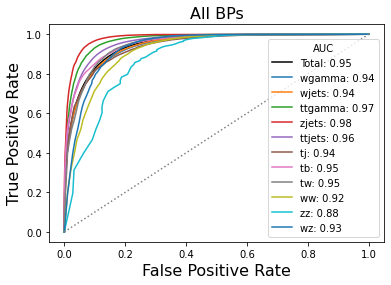

In [43]:
plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total: {:.2f}'.format(auc(fpr_total, tpr_total)))

for i, ibkg in enumerate(bkg):
    plt.plot(fpr_bkg[i,:], tpr_bkg[i,:], label = ibkg + ': {:.2f}'.format(auc(fpr_bkg[i,:], tpr_bkg[i,:])))
plt.legend(title = 'AUC')

plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)
#plt.savefig('../graph/ROC_AllBPs.png', bbox_inches='tight')

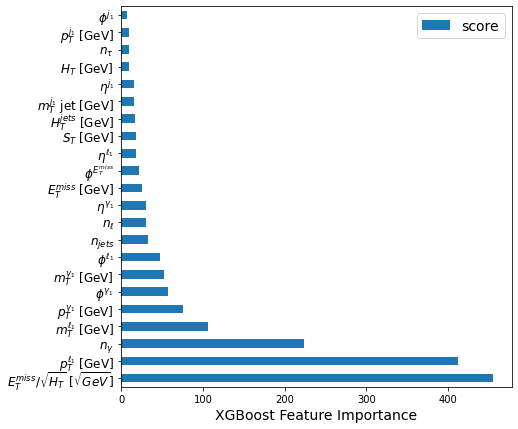

In [44]:
lst1 = ['$p_T^{\gamma_1}$ [GeV]', '$\eta^{\gamma_1}$', '$\phi^{\gamma_1}$', '$n_\gamma$',
       '$p_T^{j_1}$ [GeV]', '$\eta^{j_1}$', '$\phi^{j_1}$',
       '$p_T^{\ell_1}$ [GeV]', '$\eta^{\ell_1}$', '$\phi^{\ell_1}$', '$n_\ell$', '$n_{\\tau}$',
       '$E_T^{miss}$ [GeV]', '$\phi^{E_T^{miss}}$',
       '$H_T$ [GeV]', '$H_T^{jets}$ [GeV]', '$n_{jets}$',
       '$S_T$ [GeV]', 
       '$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]',
       '$m_T^{\gamma_1}$ [GeV]', '$m_T^{j_{1}}$ jet [GeV]', '$m_T^{\ell_1}$ [GeV]',
       'SM=0 - NP=1']

fig, ax = plt.subplots(figsize = (7,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("XGBoost Feature Importance", fontsize = 14)
ax.set_yticklabels(np.asarray(lst1)[np.argsort(values)[::-1]], fontsize = 12)

ax.legend(fontsize = 14)

#plt.savefig('../graph/ImpVars_AllBPs.png', bbox_inches='tight')

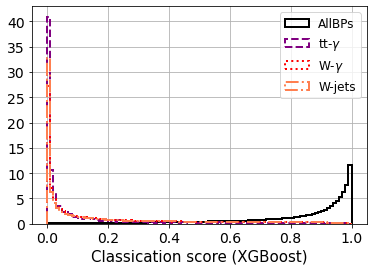

In [47]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'AllBPs', lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('../graph/MLOutput_dist_AllBPs.png', bbox_inches="tight")

In [48]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [49]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [50]:
len(np.where(bkg_flag_test == 0)[0])

735025

## Sequential selection criteria

In [84]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0 = []
for bp in np.arange(8):
    n_np0.append( len(np.where(df_test_array[:, 24] == (bp+1))[0]) )
    
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 3), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    ZN_sup = np.zeros(nbins)
    ZN_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_sup, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and ( np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_sup[icut] = np.mean(Z_norm)
            Z.append( ZN_sup[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_inf[icut] = np.mean(Z_norm)
            Z.append( ZN_inf[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut     = np.argmax(np.asarray(Z))
    indices_aux = indices[max_cut]
    max_cut     = np.argmax((ZN_inf, ZN_sup))
    if max_cut >= len(ZN_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(ZN_sup)]) + '; <Z Norm> = ' + str(ZN_sup[max_cut - len(ZN_inf)]))
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(ZN_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(ZN_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; <Z Norm> = ' + str(ZN_inf[max_cut]))
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = np.zeros(8)
for bp in np.arange(8):
    n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
    S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))
    
# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5): 
    for bp in np.arange(8):
        print('\n')
        print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp])))
        print('Expected Background = ' + str(B_expected_aux))
        print('Expected Signal = ' + str(S_expected_aux[bp]))

num lepton <= 1.3333333333333333; <Z Norm> = 0.0026064970511453633
MET $\phi$ <= 3.142; <Z Norm> = 0.0026064970511453633
jet $\phi$ <= 3.142; <Z Norm> = 0.0026064970511453633
jet $\eta$ <= 4.483; <Z Norm> = 0.0026064970511453633
num_taus <= 1.0; <Z Norm> = 0.002606704668859458
MET $p_T$ [GeV] <= 1764.05; <Z Norm> = 0.002606704668859458
$m_T$ lepton [GeV] <= 265.8167433945567; <Z Norm> = 0.0026396344598917593
MET sig [GeV] >= 13.043390176795773; <Z Norm> = 0.0039141126577690345
lepton $p_T$ [GeV] <= 189.14111111111112; <Z Norm> = 0.003987864870153776
photon $p_T$ [GeV] <= 201.79888888888888; <Z Norm> = 0.004054172170314681
$H_T$ (jets) [GeV] <= 2109.5433333333335; <Z Norm> = 0.004054834529288518
lepton $\eta$ <= 2.499; <Z Norm> = 0.004054834529288518
$H_T$ [GeV] <= 2188.46; <Z Norm> = 0.004054834529288518
photon $\eta$ <= 2.369; <Z Norm> = 0.004054834529288518
$m_T$ photon [GeV] <= 197.03950898355276; <Z Norm> = 0.004210000611469858
lepton $\phi$ <= 3.142; <Z Norm> = 0.00421000061146985

In [ ]:
write = False
if write:
    with open('../data/cuts/ALLBPs_supCuts.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/ALLBPs_infCuts.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/ALLBPs_supCuts.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/ALLBPs_infCuts.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

100%|███████████████████████████████| 2000/2000 [00:29<00:00, 68.50it/s]


Final results: for BP 1
 
Z = 3.3184679708932525; Z_std = 0.6880010465081745
B_exp = 44.243; B_exp_std = 5.300561385362875
S_exp = 24.0815; S_exp_std = 4.86311194092836


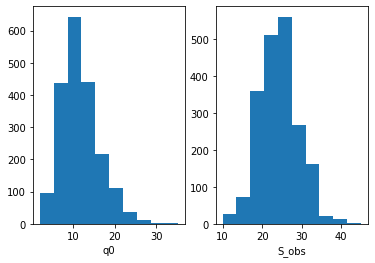

100%|███████████████████████████████| 2000/2000 [00:30<00:00, 66.23it/s]


Final results: for BP 2
 
Z = 2.6078714064631128; Z_std = 0.5870669302873777
B_exp = 44.2545; B_exp_std = 5.477748602300036
S_exp = 18.478; S_exp_std = 4.111874998100015


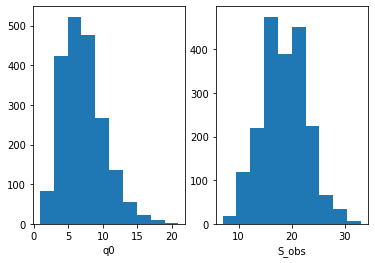

100%|███████████████████████████████| 2000/2000 [00:29<00:00, 67.52it/s]


Final results: for BP 3
 
Z = 1.7170674708124498; Z_std = 0.5164285264657559
B_exp = 44.181; B_exp_std = 5.376638261962581
S_exp = 11.935; S_exp_std = 3.4532267518945234


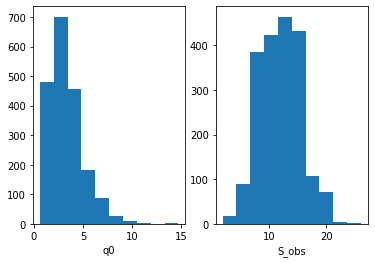

100%|███████████████████████████████| 2000/2000 [00:29<00:00, 68.28it/s]


Final results: for BP 4
 
Z = 2.3490725087043396; Z_std = 0.5816376565911183
B_exp = 44.0675; B_exp_std = 5.390263792246165
S_exp = 16.5245; S_exp_std = 4.003048806847101


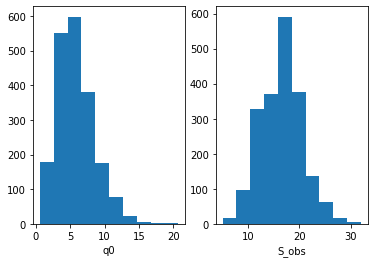

100%|███████████████████████████████| 2000/2000 [00:29<00:00, 68.28it/s]


Final results: for BP 5
 
Z = 1.452621010251225; Z_std = 0.47386651978751143
B_exp = 44.237; B_exp_std = 5.365988352577743
S_exp = 9.9405; S_exp_std = 3.181974190655857


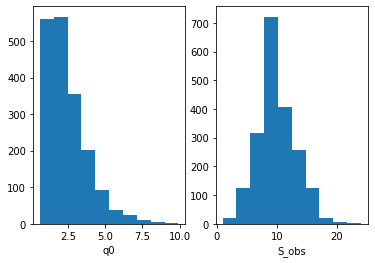

100%|███████████████████████████████| 2000/2000 [00:31<00:00, 63.84it/s]


Final results: for BP 6
 
Z = 1.8934033919526279; Z_std = 0.5333528300386431
B_exp = 43.9205; B_exp_std = 5.3940874807514945
S_exp = 13.1165; S_exp_std = 3.639632914182418


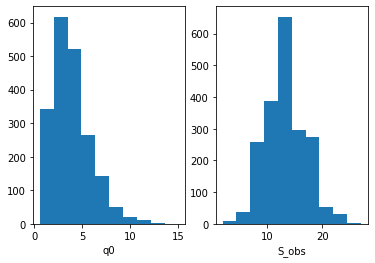

100%|███████████████████████████████| 2000/2000 [00:31<00:00, 63.99it/s]


Final results: for BP 7
 
Z = 1.1316276960294425; Z_std = 0.32312071173012563
B_exp = 43.973; B_exp_std = 5.462167243869415
S_exp = 6.4325; S_exp_std = 2.578263708389815


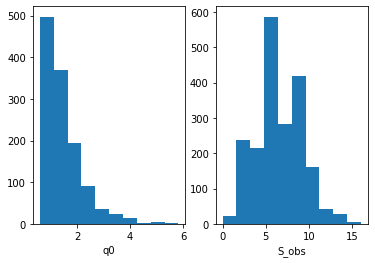

100%|███████████████████████████████| 2000/2000 [00:31<00:00, 64.27it/s]


Final results: for BP 8
 
Z = 1.3430984598969897; Z_std = 0.4172325029235957
B_exp = 43.872; B_exp_std = 5.441655630412495
S_exp = 8.8095; S_exp_std = 2.921850398292151


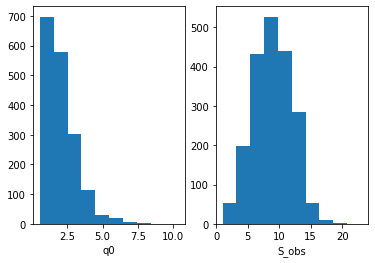

In [85]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]

for bp in np.arange(8):
    
    NP_test_pool = np.where(df_test_array[:,24] == (bp+1))[0]

    q0_exp = np.zeros(nexperiments)
    B_observed_exp = np.zeros(nexperiments)
    S_observed_exp = np.zeros(nexperiments)
    for nexp in tqdm(range(nexperiments)):
        # Let's create a pseudo-experiment
        SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
        NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
        indices_aux = np.concatenate((NP_indices, SM_indices))

        # Let's make the cuts

        variables = list(sup_cuts.keys())
        for i in range(len(variables)):
            ind_var = np.where(df_test.columns == variables[i])[0][0]
            indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                    (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                                   )[0]]
        # Let's calculate everything

        n_np = len(np.where(df_test_array[indices_aux, 24] == (bp+1))[0])

        n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

        S_observed_exp[nexp] = n_np

        # Formula discovery
        B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                               n_ttjets + n_zjets + n_wz + \
                               n_zz + n_ww + n_tj + \
                               n_tb + n_tw

        N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                     n_ttjets + n_zjets + n_wz + \
                     n_zz + n_ww + n_tj + \
                     n_tb + n_tw
        
        if (B_observed_exp[nexp] >= 5) and (n_np > 5): 
            q0_exp[nexp] = -2 * N_observed * np.log(B_observed_exp[nexp] / N_observed) -2 * (N_observed - B_observed_exp[nexp])
        else:
            q0_exp[nexp] = -99
            
    q0_exp = q0_exp[np.where(q0_exp > 0)[0]]
    print('Final results: for BP ' + str(bp+1) + '\n ')
    print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
    print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
    print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))
    fig,ax = plt.subplots(1,2)
    
    ax[0].hist(q0_exp)
    ax[0].set_xlabel('q0')
    ax[1].hist(S_observed_exp)
    ax[1].set_xlabel('S_obs')
    plt.show()

In [99]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
print(imp_vars)

['MET sig [GeV]' 'lepton $p_T$ [GeV]' 'num photon' '$m_T$ lepton [GeV]']


In [88]:
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('white'), cmap_name = 'NP_cmap')

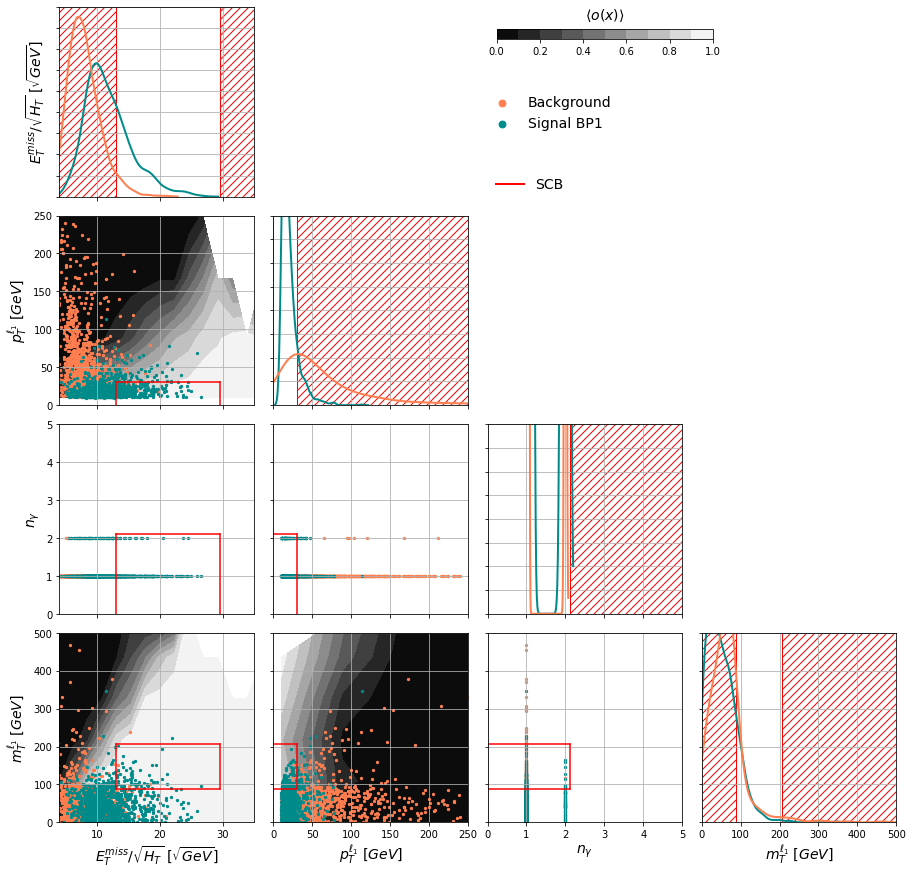

In [100]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  1000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  1000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[4,35], [0,250], [0,5], [0,500]]
ylimites = [[0,0.18], [0,0.04], [0,0.02], [0,0.01]]

rand_ind = np.random.choice(range(len(df_test)), size =  len(df_test), replace = False)
aux = df_test.iloc[rand_ind]
y_pred_aux = y_pred_xg[rand_ind]

#%with open('../data/cuts/ALLBPs_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
#%    sup_cuts = json.load(fp)
#%with open('../data/cuts/ALLBPs_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
#%    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = 'solid')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].set_ylim(ylimites[i])
            else:
                stats, xedge, yedge, _ = binned_statistic_2d(aux[imp_vars[j]], aux[imp_vars[i]], y_pred_aux, bins = 22)
                im_NP = ax[i,j].contourf(xedge[:-1], yedge[:-1], stats.T, cmap=NP_cmap, zorder = 0, levels = np.linspace(0,1,11))
                ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'coral', rasterized=True, label = 'Background')
                ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'darkcyan', rasterized=True, label = 'Signal BP1')
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                #ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'silver', zorder = 1)
                #ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'silver', zorder = 1)
                #ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'silver', zorder = 1)
                #ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 1)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')

                #%if (i==1) & (j==0):
                #%    # Create 2D interpolation function
                #%    x = xedge[:-1] + (xedge[1] - xedge[0])/2
                #%    y = yedge[:-1] + (yedge[1] - yedge[0])/2
                #%    x_new = np.linspace(limites[j][0], limites[j][1], 10000)
                #%    y_new = np.linspace(limites[i][0], limites[i][1], 10000)
                #%    X_new, Y_new = np.meshgrid(x_new, y_new)

                    # Interpolate values on the finer grid
                #%    f = bisplrep(aux[imp_vars[j]][:100000], aux[imp_vars[i]][:100000], y_pred_aux[:100000],kx=2,ky=2)
                #%    Z_new = bisplev(x_new, y_new,f)

                #%    ax[i,j].contourf(x_new, y_new, Z_new.T,cmap=NP_cmap,levels=np.linspace(0,1,10),zorder=1)

                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel('$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]', fontsize = 14)
ax[3,1].set_xlabel('$p_T^{\ell_{1}}$ [$GeV$]', fontsize = 14)
ax[3,2].set_xlabel('$n_\gamma$', fontsize = 14)
ax[3,3].set_xlabel('$m_T^{\ell_1}$ [$GeV$]', fontsize = 14)

ax[0,0].set_ylabel('$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]', fontsize = 14)
ax[1,0].set_ylabel('$p_T^{\ell_{1}}$ [$GeV$]', fontsize = 14)
ax[2,0].set_ylabel('$n_\gamma$', fontsize = 14)
ax[3,0].set_ylabel('$m_T^{\ell_1}$ [$GeV$]', fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])



#%with open('../data/cuts/BP1_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
#%    sup_cuts = json.load(fp)
#%with open('../data/cuts/BP1_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
#%    inf_cuts = json.load(fp)

#%for i in range(4):
#%    for j in range(4):
#%        if i >= j:
#%            if i==j:
#%                pass
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
#%            else:
#%                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
#%                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
#%                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
#%                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 


# Legends------------------------------------------

ax[1,0].legend(loc = 'upper right', bbox_to_anchor=(2.9, 1.7), fontsize = 14, frameon = False, markerscale=3)

#%cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal', pad = 0.5)
#%cbar_SM.set_label('$P(S|B)$', labelpad=-50)
cax = fig.add_axes([0.53, 0.85, 0.2, 0.01])
cbar_NP = plt.colorbar(im_NP, cax=cax, orientation = 'horizontal')
cbar_NP.set_label(r'$\langle o(x) \rangle$', labelpad=-50, fontsize = 14)

patch1 = mlines.Line2D([], [], color='red', label='SCB', linestyle='-', markerfacecolor='none', markeredgewidth=2, lw = 2)
patch2 = mlines.Line2D([], [], color='red', label='BP 1', linestyle='-.', markerfacecolor='none', markeredgewidth=2, lw = 2)

# Add custom legend with boxes
ax[0,0].legend(handles=[patch1], loc = 'lower left', bbox_to_anchor=(2.18, -0.04), fontsize = 14, frameon = False )

#plt.savefig('../graph/ALLBPs_ImpVars_dist.pdf', bbox_inches='tight')

## Binned likelihood

In [101]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [102]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(726723,)


In [103]:
B_expected = int(B_expected)

147986

B_expected:  147986

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


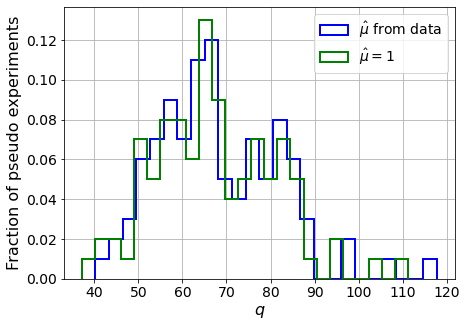

BP1

S_expected:  641.5741522357895
muhat mean:  1.0305000000000002
Z_bins:  8.139009055692101
std Z_bins:  0.8576719225193317
Z_bins mu=1:  8.143377781115536
std Z_bins mu=1:  0.8385108919889018

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


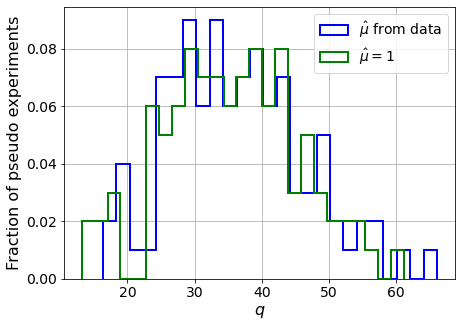

BP2

S_expected:  582.276369587
muhat mean:  1.0425
Z_bins:  5.970557100330167
std Z_bins:  0.8440260084063379
Z_bins mu=1:  5.97466289665653
std Z_bins mu=1:  0.8236104323380287

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


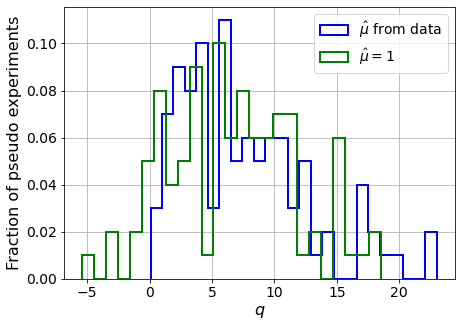

BP3

S_expected:  278.89596440145
muhat mean:  0.9905000000000002
Z_bins:  2.532710502958502
std Z_bins:  1.0210264228629018
Z_bins mu=1:  2.530602554544558
std Z_bins mu=1:  1.0075387916846072

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


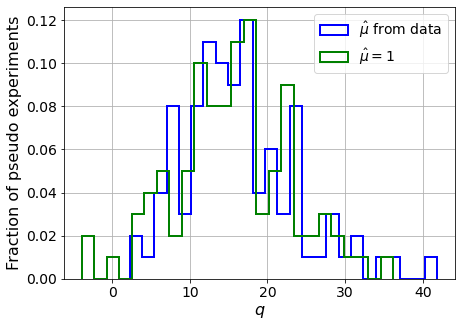

BP4

S_expected:  295.9616317164375
muhat mean:  0.9980000000000001
Z_bins:  3.934157201597684
std Z_bins:  0.9372497151461516
Z_bins mu=1:  3.934157201597684
std Z_bins mu=1:  0.9448983593066597

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


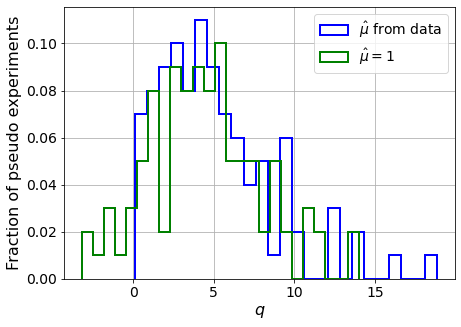

BP5

S_expected:  177.36868635267194
muhat mean:  1.013
Z_bins:  2.0705760538248263
std Z_bins:  0.8901236513629738
Z_bins mu=1:  2.0705760538248263
std Z_bins mu=1:  0.837241818812958

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


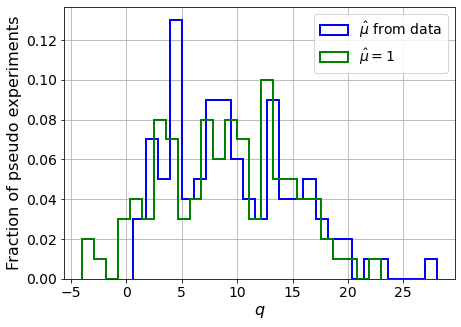

BP6

S_expected:  192.94194642254212
muhat mean:  1.016
Z_bins:  2.9924407168044262
std Z_bins:  0.9451807948599059
Z_bins mu=1:  2.995318294320167
std Z_bins mu=1:  0.9457376075640086

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


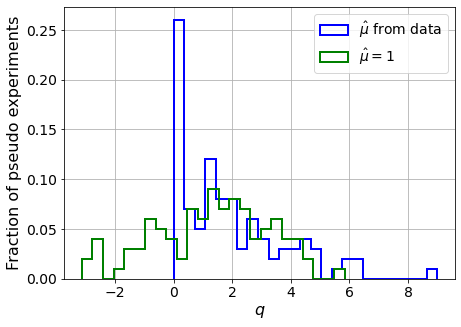

BP7

S_expected:  92.75013942173914
muhat mean:  0.9895
Z_bins:  1.1971543940418599
std Z_bins:  0.768105538587275
Z_bins mu=1:  1.2128695754864016
std Z_bins mu=1:  0.7976699971379

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


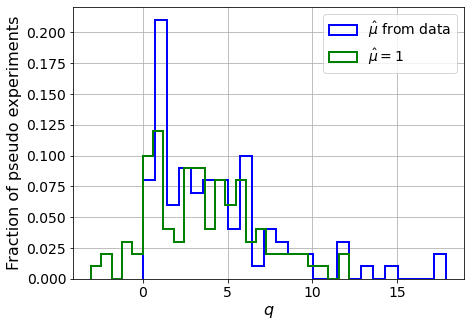

BP8

S_expected:  107.83234905519998
muhat mean:  1.0635
Z_bins:  1.845496938867122
std Z_bins:  0.9942660032749147
Z_bins mu=1:  1.8451509558777022
std Z_bins mu=1:  0.849159975321819

--------



In [107]:
D_or_E = 'discovery'
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]]
# requested number of pseudo experiments
num_pseudo = 100
    
print('B_expected: ', B_expected)
print('')
Z_BL_BPs = np.ones(8) * (-99)
Z_BL_std_BPs = np.ones(8) * (-99)
muhat_BL = np.ones(8) * (-99)
for bp in BPS_analyzed:
    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
    
    Z_BL_BPs[bp] = Z_BL[0]
    Z_BL_std_BPs[bp] = Z_BL[1]
    muhat_BL[bp] = Z_BL[2]
    
    print('BP' + str(bp+1) + '\n')
    print('S_expected: ', S_expected[bp])
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=1: ', Z_BL[3])
    print('std Z_bins mu=1: ', Z_BL[4])
    print('')
    print('--------\n')

## KDE

In [53]:
import time
start = time.time()

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [           -inf            -inf            -inf            -inf
            -inf  1.24010533e+04  1.20723498e+04  1.16547971e+04
  1.11510457e+04  1.05496185e+04  9.83259068e+03  9.00864321e+03
  8.04308351e+03  6.89404846e+03  5.54359960e+03  3.96822718e+03
  2.13693470e+03  1.12688561e+01 -2.39456008e+03 -5.19533307e+03]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           

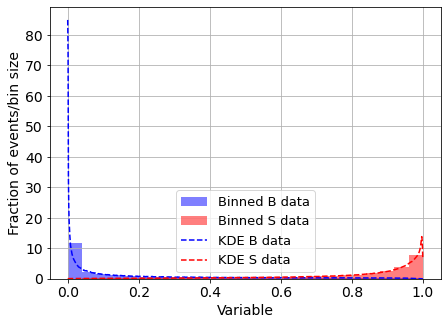

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503


In [54]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] > 0)[0]]

kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

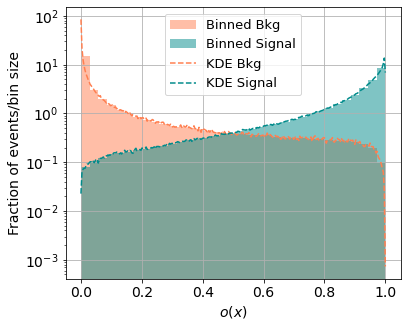

In [55]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,300)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='coral',alpha=0.5, linewidth=2, label=r'Binned Bkg');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='darkcyan',alpha=0.5, linewidth=2, label=r'Binned Signal');

plt.plot(s_vals, dens_bkg, color='coral',label=r'KDE Bkg',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='darkcyan',label=r'KDE Signal',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("$o(x)$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

#plt.savefig('../graph/KDE_fit_ALLBPs.pdf', bbox_inches='tight')

In [57]:

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


0:10000
3 done
4 done
0.001173668206624897
0.001173668206624897
B_expected:  147986
S_expected:  641

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


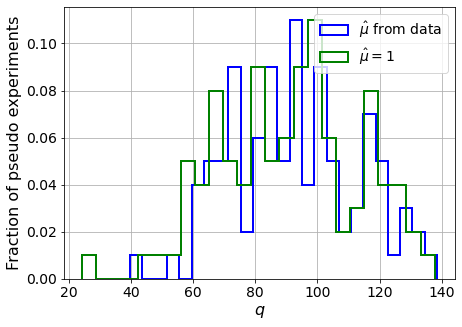

BP1
muhat mean:  0.8945000000000002
Z_MLL:  9.647641691976595
std Z_MLL:  1.045353984072906
Z_MLL mu=1:  9.603656233004642
std Z_MLL mu=1:  1.1676840407597433
Z_MLL new:  6.354161814328931
std Z_MLL new:  1.0095272483481297

--------

1:10000
3 done
4 done
0.0008182493498273009
0.0008182493498273009
B_expected:  147986
S_expected:  582

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


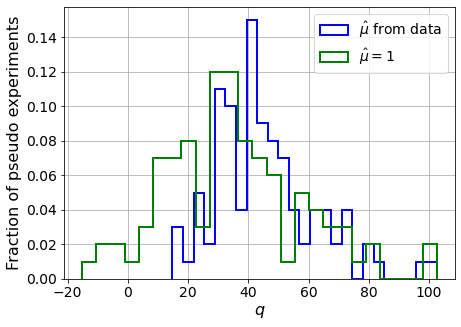

BP2
muhat mean:  0.6555
Z_MLL:  6.5103315638652
std Z_MLL:  1.3002274694208835
Z_MLL mu=1:  5.742335374615343
std Z_MLL mu=1:  1.9851734508181476
Z_MLL new:  3.609434489300808
std Z_MLL new:  1.340161245445475

--------

2:10000
3 done
4 done
0.0013032328944203183
0.0013032328944203183
B_expected:  147986
S_expected:  278

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


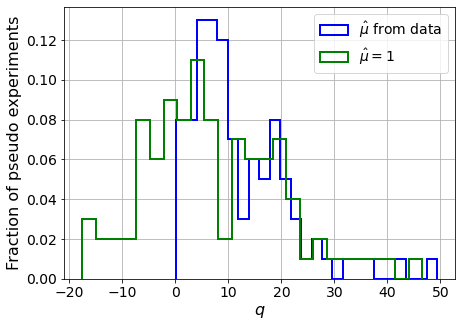

BP3
muhat mean:  0.6135000000000002
Z_MLL:  3.072094848370907
std Z_MLL:  1.5155869879798127
Z_MLL mu=1:  2.299841314888914
std Z_MLL mu=1:  2.782623199008984
Z_MLL new:  0.19349036280672116
std Z_MLL new:  7.19436276345509

--------

3:10000
3 done
4 done
0.0012006894189754917
0.0012006894189754917
B_expected:  147986
S_expected:  295

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


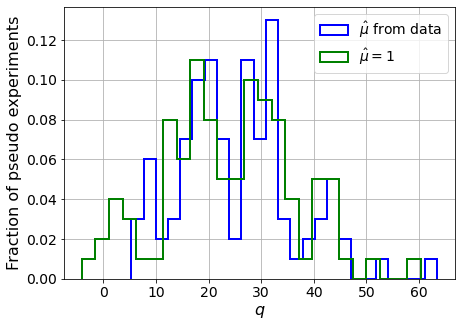

BP4
muhat mean:  0.8810000000000001
Z_MLL:  4.956614014793312
std Z_MLL:  1.1113098045363001
Z_MLL mu=1:  4.8982328021198605
std Z_MLL mu=1:  1.2545961827963519
Z_MLL new:  2.212231397929577
std Z_MLL new:  1.167044477553983

--------

4:10000
3 done
4 done
0.001078886942308321
0.001078886942308321
B_expected:  147986
S_expected:  177

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


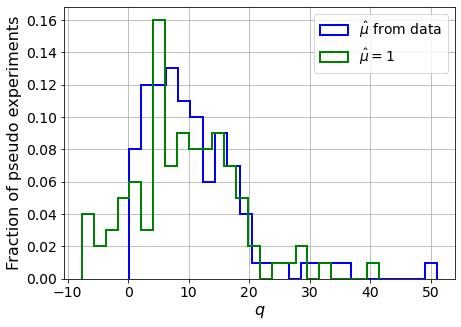

BP5
muhat mean:  0.8795000000000002
Z_MLL:  3.0197149043895477
std Z_MLL:  1.3750158642190895
Z_MLL mu=1:  2.9749478278100296
std Z_MLL mu=1:  1.456570892537538
Z_MLL new:  0.32577030470799206
std Z_MLL new:  4.091421994565679

--------

5:10000
3 done
4 done
0.0012094956986867969
0.0012094956986867969
B_expected:  147986
S_expected:  192

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


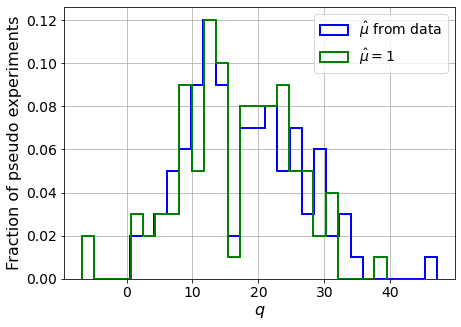

BP6
muhat mean:  1.0775000000000001
Z_MLL:  4.114557590360412
std Z_MLL:  1.0533451250829031
Z_MLL mu=1:  4.089130168096728
std Z_MLL mu=1:  1.0362297908868066
Z_MLL new:  1.4042119741020722
std Z_MLL new:  1.111906577535651

--------

6:10000
3 done
4 done
0.0008218372800029231
0.0008218372800029231
B_expected:  147986
S_expected:  92

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


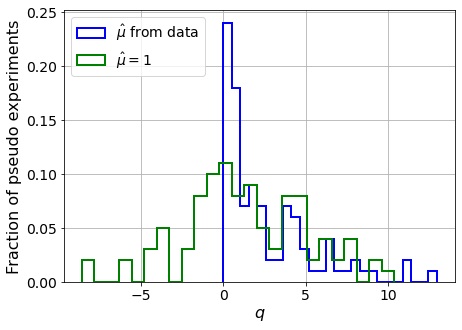

BP7
muhat mean:  0.7029999999999998
Z_MLL:  1.2668123280617778
std Z_MLL:  1.1097109517788362
Z_MLL mu=1:  1.0937742813708977
std Z_MLL mu=1:  1.692358090242204
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

7:10000


/tmp/ipykernel_1817670/757540525.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0008105506655979512
0.0008105506655979512
B_expected:  147986
S_expected:  107

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


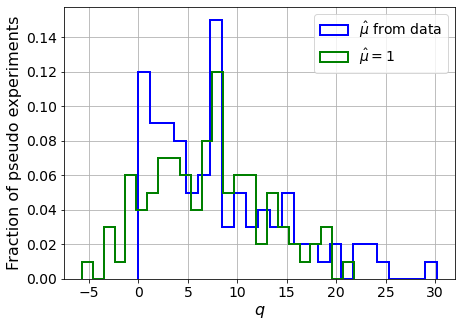

BP8
muhat mean:  1.151
Z_MLL:  2.7358309731607595
std Z_MLL:  1.1962542413431447
Z_MLL mu=1:  2.6916214097823943
std Z_MLL mu=1:  1.0565098484681186
Z_MLL new:  0.2632438619701057
std Z_MLL new:  3.268073188372424

--------



In [235]:
D_or_E = "discovery"

Z_MLL_BPs = np.ones(8) * (-99)
Z_MLL_std_BPs = np.ones(8) * (-99)
Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
muhat_MLL = np.ones(8) * (-99)

BPS_analyzed = [0,1,2,3,4,5,6,7]
for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected[bp]))
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100)
    #Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')

    Z_MLL_BPs[bp] = Z_MLL[0]
    Z_MLL_std_BPs[bp] = Z_MLL[1]
    muhat_MLL[bp] = Z_MLL[2]
    
    Z_MLL_BPs_new[bp] = abs( np.median(Z_MLL[6]) )**0.5
    Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])
    
    print('BP' + str(bp+1))
    print('muhat mean: ', Z_MLL[2])
    print('Z_MLL: ', Z_MLL[0])
    print('std Z_MLL: ', Z_MLL[1])
    print('Z_MLL mu=1: ', Z_MLL[3])
    print('std Z_MLL mu=1: ', Z_MLL[4])
    print('Z_MLL new: ', Z_MLL_BPs_new[bp])
    print('std Z_MLL new: ', Z_MLL_std_BPs_new[bp])
    print('')
    print('--------\n')

In [236]:
stop = time.time()
print(f'Last {(stop-start)/60} minutes to perform the MLL+KDE')

Last 196.03915234009426 minutes to perform the MLL+KDE


### Let's try

In [194]:
def MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected, num_pseudo):

	# FIND THE SIGNIFICANCE WITH MLL USING THE TEST STATISTIC FORMALISM (gives statistical error) 
	# Inputs:
		# D_or_E -> statistical test. Options: "exclusion" or "discovery"
		# pB_B_data -> array with BACKGROUND PDF evaluated in each BACKGROUND event,   p_B(background),   shape (len(background), )
		# pS_B_data -> array with SIGNAL PDF evaluated in each BACKGROUND event,       p_B(background),   shape (len(background), )
		# pB_S_data -> array with BACKGROUND PDF evaluated in each SIGNAL event,       p_B(background),   shape (len(signal), )
		# pS_S_data -> array with SIGNAL PDF evaluated in each SIGNAL event,           p_B(background),   shape (len(signal), )
		# B_expected -> number of Background events expected in a pseudo experiment
		# S_expected -> number of Signal events expected in a pseudo experiment
		# num_pseudo -> number of pseudo experiments that are used to compute the test statistic distribution
		
	# Outputs:
		# Z_bins -> value of the significance (using mu_hat that fits the data sample)
		# Z_bins_std -> statistical error (1 sigma) of the significance (using mu_hat that fits the data sample)
		# muhat_mean_bins -> mean of the mu_hat computed from the data sample
		# Z_bins_mu -> value of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
		# Z_bins_std_mu -> statistical error (1 sigma) of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]

    indices_S = [i for i in range(len(pS_S_data))]
        
        
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    mu_list = []
    q_list = []
    
    # loop over the number of pseudo experiments
    
    fail_pseudo = 0
    for its in range(num_pseudo):
        
        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)

        if D_or_E == 'discovery': # Background and Signal events

            # this pseudo-exp has S_rand number of S events
            S_rand = np.random.poisson(int(S_expected))

            ran_ind = np.random.choice(indices_S, S_rand)
            pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

            pB_S_data_shuf = []
            pS_S_data_shuf = []

            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_S_data_shuf.append(pB_S_data[i])
                pS_S_data_shuf.append(pS_S_data[i])

            pB_S_data_shuf  = np.array(pB_S_data_shuf)
            pS_S_data_shuf  = np.array(pS_S_data_shuf)

            
            # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
            prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

            # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
            prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

            #%pb_ps_exp = prob_x_given_B / prob_x_given_S
            pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
            
            #%plt.scatter(pb_ps_exp, prob_x_given_B / prob_x_given_S)
            #%plt.xscale('log')
            #%plt.yscale('log')
            #%fig,ax = plt.subplots(1,2)
            #%ax[0].scatter(pb_ps_B_data, pB_B_data_shuf / pS_B_data_shuf)
            #%ax[0].set_xscale('log')
            #%ax[0].set_yscale('log')
            #%#ax[1].plot([0,400],[0,400])
            #%ax[1].scatter(pb_ps_S_data, pB_S_data_shuf / pS_S_data_shuf)
            #%#ax[1].plot([0,400],[0,400])
            plt.show()
            
            mu = find_mu(pb_ps_exp, S_expected, B_expected)
            print(mu)
            print(find_mu(prob_x_given_B / prob_x_given_S, S_expected, B_expected))
            if mu < 0: mu = 0
            if mu > 2: mu = 2
            mu_list.append(mu)
            q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected))

            if np.min(prob_x_given_B) == 0:
                print('There are events with p(s)=0')
                prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
                print(np.min(prob_x_given_B))

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

            # approximation: mu_hat=1 (discovery)
            q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


            # compute mu_hat from implicit equation
            def f_mu_hat(mu_h, prob_x_given_B=prob_x_given_B, prob_x_given_S=prob_x_given_S):
                return sum ( [x / ( (x * mu_h * S_expected) + (y * B_expected) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) - 1


            muhat_selected_MLL = fsolve(f_mu_hat,1, xtol=1e-2)[0]

            # save the computed mu_hat for each pseudo_experiment
            muhat_selected_MLL_list.append(muhat_selected_MLL)


            # compute the test statistic for each pseudo_exp considering mu_hat
            if muhat_selected_MLL > 0:
                q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

            else:
                q_muhat_MLL.append( 0 )
    
    
    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)

    Z_MLL = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
    
    
    # With the approximation of mu_hat
    Z_MLL_mu = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_std_mu = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu)
    
    
    return Z_MLL, Z_MLL_std, muhat_mean_MLL, Z_MLL_mu, Z_MLL_std_mu,muhat_selected_MLL_list,q_muhat_MLL, mu_list, q_list





In [195]:
bp = 3
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

print(str(bp) + ':' + str(len(pred_XG_NP)))
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

print('B_expected: ', int(B_expected))
print('S_expected: ', int(S_expected[bp]))
print('')

Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100)


3:10000
3 done
4 done
0.0015329324375589295
0.0015329324375589295
B_expected:  147986
S_expected:  295

0.6530950236632717
1.1942406721134864
0.3145597824230597
0.9670846201724531
0.2978737999570837
0.8520866186322589
0.2546727595269426
0.7695219086261763
0.2702684861007098
0.7495963849630929
0.36129751521263265
0.8211423947436195
0.32852874360974677
0.8911177539001951
0.4528461058775343
1.070126017288286
0.5360150744773284
1.090050023939058
0.2070577825225311
0.7730116512967664


KeyboardInterrupt: 

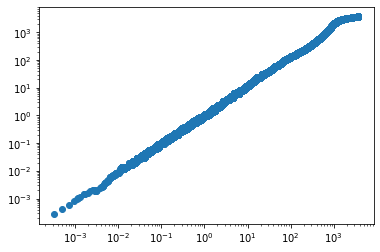

0.3931211824561125
0.8915060029575975
0.8915063105640938


In [209]:
indices_B = [i for i in range(len(pS_B_data))]

indices_S = [i for i in range(len(pS_S_data))]


muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []


# this pseudo-exp has B_rand number of B events
B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)

# this pseudo-exp has S_rand number of S events
S_rand = np.random.poisson(int(S_expected[bp]))

ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)


# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

#%pb_ps_exp = prob_x_given_B / prob_x_given_S
pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])

plt.scatter(pb_ps_exp, prob_x_given_B / prob_x_given_S)
plt.xscale('log')
plt.yscale('log')
#%fig,ax = plt.subplots(1,2)
#%ax[0].scatter(pb_ps_B_data, pB_B_data_shuf / pS_B_data_shuf)
#%ax[0].set_xscale('log')
#%ax[0].set_yscale('log')
#%#ax[1].plot([0,400],[0,400])
#%ax[1].scatter(pb_ps_S_data, pB_S_data_shuf / pS_S_data_shuf)
#%#ax[1].plot([0,400],[0,400])
plt.show()

mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
print(mu)
print(find_mu(prob_x_given_B / prob_x_given_S, S_expected[bp], B_expected))
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# compute mu_hat from implicit equation
def f_mu_hat(mu_h, prob_x_given_B=prob_x_given_B, prob_x_given_S=prob_x_given_S):
    return sum ( [x / ( (x * mu_h * S_expected[bp]) + (y * B_expected) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) - 1


muhat_selected_MLL = fsolve(f_mu_hat,1, xtol=1e-2)[0]
print(muhat_selected_MLL)

Text(0, 0.5, 'KDE')

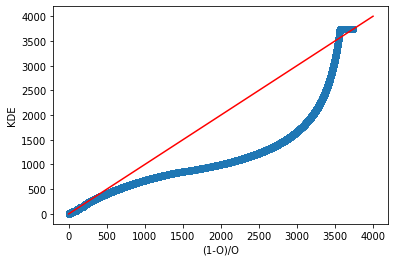

In [223]:
plt.scatter(prob_x_given_B[:B_rand] / prob_x_given_S[:B_rand], pb_ps_exp[:B_rand])
#plt.xscale('log')
#plt.yscale('log')
plt.plot([1e-3,4e3],[1e-3,4e3],c = 'red')
plt.xlabel('(1-O)/O')
plt.ylabel('KDE')

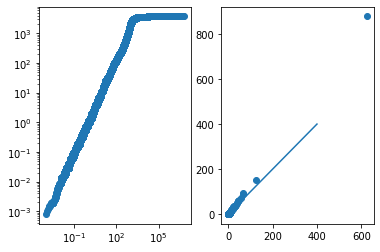

In [189]:
fig,ax = plt.subplots(1,2)

ax[0].scatter((1-pred_XG_SM)/pred_XG_SM, pB_B_data / pS_B_data)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot([0,400],[0,400])
ax[1].scatter((1-pred_XG_NP)/pred_XG_NP, pB_S_data / pS_S_data)
ax[1].plot([0,400],[0,400])

In [190]:
print(Z_MLL[0], Z_MLL[1])

5.3811970408441665 1.2407660614726699


In [191]:
print(abs( np.median(Z_MLL[8]) )**0.5)

2.693032119628668


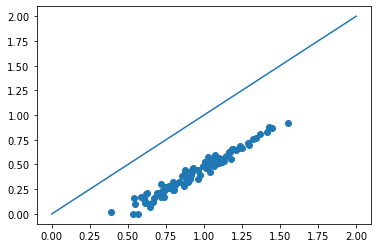

In [192]:
plt.scatter(Z_MLL[5], Z_MLL[7])
plt.plot([0,2],[0,2])

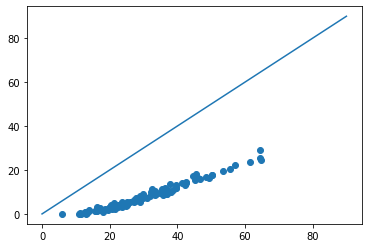

In [193]:
plt.scatter(Z_MLL[6], Z_MLL[8])
plt.plot([0,90],[0,90])

In [118]:
pb_ps_B_data = (1 - pred_XG_SM) / pred_XG_SM
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337

In [116]:
np.max(pB_B_data / pS_B_data)

3736.337703153999

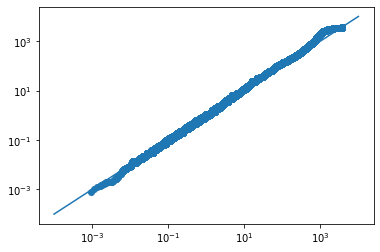

In [119]:
fig,ax = plt.subplots(1,1)

ax.scatter(pb_ps_B_data, pB_B_data / pS_B_data)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(1e-4,1e4)
#ax.set_ylim(1e-4,1e4)
ax.plot([1e-4,1e4], [1e-4,1e4])



In [122]:
start = time.time()

D_or_E = "discovery"

indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
BPS_analyzed = [0,1,2,3,4,5,6,7]

for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS
    mu_list = []
    q_list = []
    for its in range(100):
        B_rand = np.random.poisson(int(B_expected))
        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)
        pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

        pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
        
        mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
        if mu < 0: mu = 0
        if mu > 2: mu = 2
        mu_list.append(mu)
        q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))


    
    Z_MLL_aux = abs( np.median(q_list) )**0.5
    Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)
    Z_MLL_BPs_new[bp] = Z_MLL_aux
    Z_MLL_std_BPs_new[bp] = Z_MLL_std_aux
    
    print('BP' + str(bp+1))
    print('muhat mean: ', np.mean(mu_list))
    print('Z_MLL: ', Z_MLL_aux)
    print('std Z_MLL: ', Z_MLL_std_aux)
    print('')
    print('--------\n')
    
stop = time.time()
print(f'Last {(stop-start)/60} minutes to perform the MLL')

0:10000
BP1
muhat mean:  0.5442385047467352
Z_MLL:  6.109123444572321
std Z_MLL:  1.2123884367551674

--------

1:10000
BP2
muhat mean:  0.3214808589536529
Z_MLL:  3.6939276760846163
std Z_MLL:  1.1017282297370747

--------

2:10000
BP3
muhat mean:  0.0974402414695244
Z_MLL:  0.18822815395286005
std Z_MLL:  4.5450778118234725

--------

3:10000
BP4
muhat mean:  0.3823396975331739
Z_MLL:  2.6417028317976627
std Z_MLL:  1.0201257683993008

--------

4:10000
BP5
muhat mean:  0.10804492916927216
Z_MLL:  0.06299995003594464
std Z_MLL:  10.900230841905575

--------

5:10000
BP6
muhat mean:  0.3645914169005714
Z_MLL:  1.617844385175915
std Z_MLL:  1.2889051380132766

--------

6:10000


/tmp/ipykernel_1817670/256691188.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)


BP7
muhat mean:  0.03924409566239821
Z_MLL:  0.0
std Z_MLL:  inf

--------

7:10000
BP8
muhat mean:  0.20397367896242258
Z_MLL:  0.1450419818870122
std Z_MLL:  5.654111573570895

--------

Last 0.07608150641123454 minutes to perform the MLL


(0.0, 20.0)

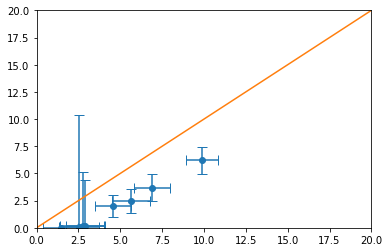

In [120]:
plt.errorbar(Z_MLL_BPs, Z_MLL_BPs_new, xerr=Z_MLL_std_BPs, yerr=Z_MLL_std_BPs_new, fmt='o', capsize=5)
plt.plot([0,20],[0,20])
plt.xlim(0,20)
plt.ylim(0,20)

In [112]:
print(np.min(pB_B_data))
pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
print(np.min(pB_B_data))

0.012822047002307902
0.012822047002307902


In [154]:
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == 1)[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

In [155]:
pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

3 done
4 done
0.001973469036674877
0.001973469036674877


In [156]:
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

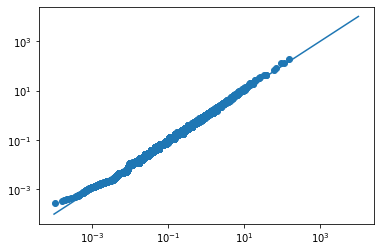

In [157]:
plt.scatter(pb_ps_S_data, pB_S_data / pS_S_data)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [132]:
indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

In [147]:
S_expected = S_expected[0]

In [184]:
mu_list = []
q_muhat_new_list = []

q_muhat_MLL_mu_aprox_list = []

muhat_MLL_list = []
q_muhat_MLL_list = []
for its in tqdm(range(100)):
    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf  = pB_B_data[ran_ind]
    pS_B_data_shuf  = pS_B_data[ran_ind]

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf  = pB_S_data[ran_ind]
    pS_S_data_shuf  = pS_S_data[ran_ind]

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
    mu = find_mu(pb_ps_exp, S_expected, B_expected)
    mu_list.append(mu)
    #%print("Valor de mu:", mu)

    q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
    #%print(q_muhat_new)
    q_muhat_new_list.append(q_muhat_new)
    
    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
    q_muhat_MLL_mu_aprox_list.append(q_muhat_MLL_mu_aprox)
    #%print(q_muhat_MLL_mu_aprox)
    
    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment

    #%print('muhat0', muhat_selected_MLL)
    muhat_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
    #%print(q_muhat_MLL)
    q_muhat_MLL_list.append(q_muhat_MLL)


In [185]:
muhat_mean_MLL = np.mean(muhat_MLL_list)

Z_MLL = abs( np.median(q_muhat_MLL_list) )**0.5
Z_MLL_std = np.std(q_muhat_MLL_list) / (2.*Z_MLL)
print(f'ZMLL: {Z_MLL} $\pm$ {Z_MLL_std} ')

muhat_mean_MLL = np.mean(mu_list)

Z_MLL = abs( np.median(q_muhat_new_list) )**0.5
Z_MLL_std = np.std(q_muhat_new_list) / (2.*Z_MLL)
print(f'Z new: {Z_MLL} $\pm$ {Z_MLL_std} ')

ZMLL: 9.317668003149484 $\pm$ 1.147704000162548 
Z new: 6.447860629854573 $\pm$ 1.163543629839523 


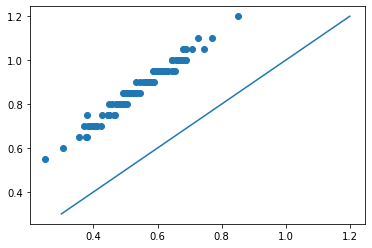

In [186]:
plt.scatter(mu_list, muhat_MLL_list)
plt.plot([0.3,1.2],[0.3,1.2])

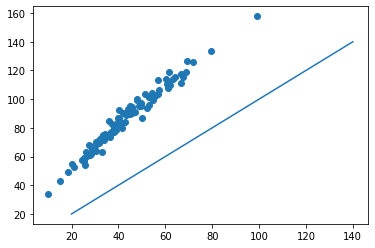

In [187]:
plt.scatter(q_muhat_new_list, q_muhat_MLL_list)
plt.plot([20,140],[20,140])

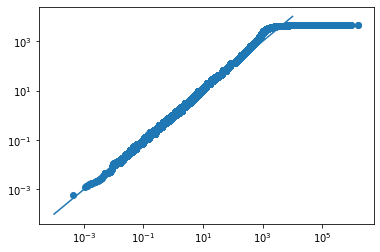

In [160]:
plt.scatter(pb_ps_exp, prob_x_given_B/prob_x_given_S)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [172]:
mu = find_mu(pb_ps_exp, S_expected, B_expected)
print("Valor de mu:", mu)

q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
print(q_muhat_new)

Valor de mu: 0.44645641239308653
24.166161124378277


In [173]:
# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
print(q_muhat_MLL_mu_aprox)

59.967517429790405


In [163]:
# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break


# save the computed mu_hat (within range) for each pseudo_experiment

print('muhat2', sum_muhat_two)
print('muhat0', sum_muhat_zero)
print(muhat_selected_MLL)


# compute the test statistic for each pseudo_exp considering mu_hat
q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
print(q_muhat_MLL)

                

muhat2 0.8961234816352464
muhat0 1.1638868810727716
0.8
63.66409979037803


0:10000
3 done
4 done
0.001721028958048736
0.001721028958048736
B_expected:  147986
S_expected:  641

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


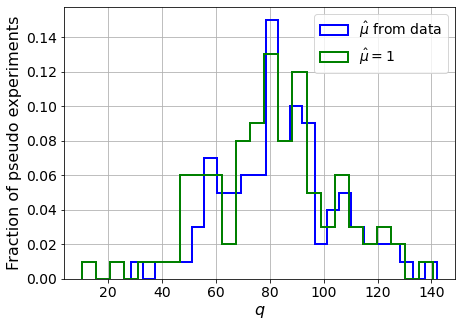

BP1
muhat mean:  0.8634999999999999
Z_MLL:  9.096951076680819
std Z_MLL:  1.138374475447136
Z_MLL mu=1:  8.980095994461541
std Z_MLL mu=1:  1.306797849416438

--------

1:10000
3 done
4 done
0.002030144740528514
0.002030144740528514
B_expected:  147986
S_expected:  582

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


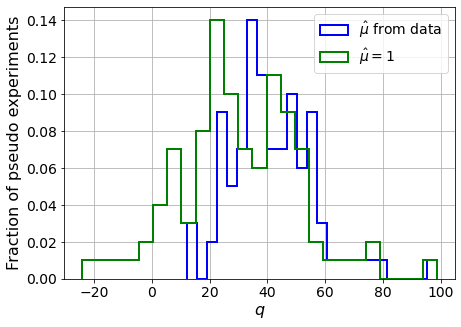

BP2
muhat mean:  0.6470000000000001
Z_MLL:  6.2861269460759335
std Z_MLL:  1.1457998889842997
Z_MLL mu=1:  5.414980994687844
std Z_MLL mu=1:  1.9011878352246527

--------

4:10000
3 done
4 done
0.002073417992791542
0.002073417992791542
B_expected:  147986
S_expected:  177

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


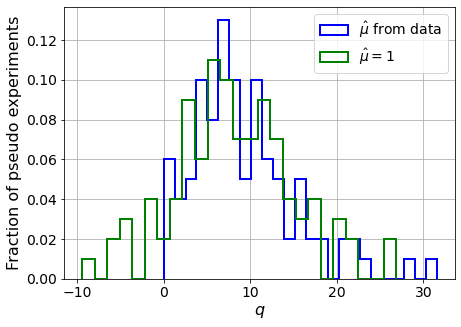

BP5
muhat mean:  0.853
Z_MLL:  2.8424321835072397
std Z_MLL:  1.0670429437461688
Z_MLL mu=1:  2.780341210288127
std Z_MLL mu=1:  1.2305447476669242

--------

7:10000
3 done
4 done
0.001864271943901527
0.001864271943901527
B_expected:  147986
S_expected:  107

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


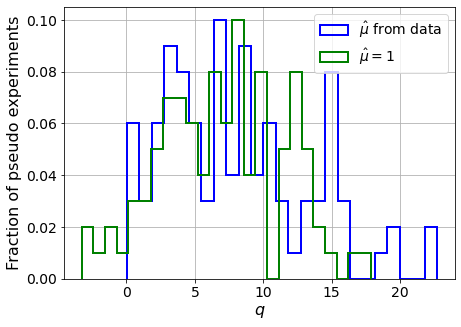

BP8
muhat mean:  1.241
Z_MLL:  2.687331059577332
std Z_MLL:  0.9798436365439029
Z_MLL mu=1:  2.657345857927333
std Z_MLL mu=1:  0.8466127214984356

--------



ValueError: 'a' cannot be empty unless no samples are taken

## Loop varying ML